In [1]:
# !pip install pillow
# !pip install fastai==2.5.3
# !pip install fastai2_extes
# !pip install matplotlib_venn

In [2]:
import random

import numpy as np
import pandas as pd

import torch
from fastai.vision.all import *
from PIL import Image

from fastai2_extensions.interpret.all import *
import time

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

**Question 1: Utilisez le “seed number” 2021 dans tout votre travail.**

In [4]:
seed = 2021
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

**Question 2:Chargez les images avec la librairie fastai et en visualisez un lot (batch)**

In [5]:
driver = pd.read_csv('driver_imgs_list.csv')
display(driver.sample(5))
display(driver.shape)

,subject,classname,img
11176,p041,c6,img_6089.jpg
2091,p014,c5,img_11781.jpg
15668,p051,c3,img_244.jpg
9242,p026,c9,img_12588.jpg
10069,p035,c9,img_49391.jpg


(22424, 3)

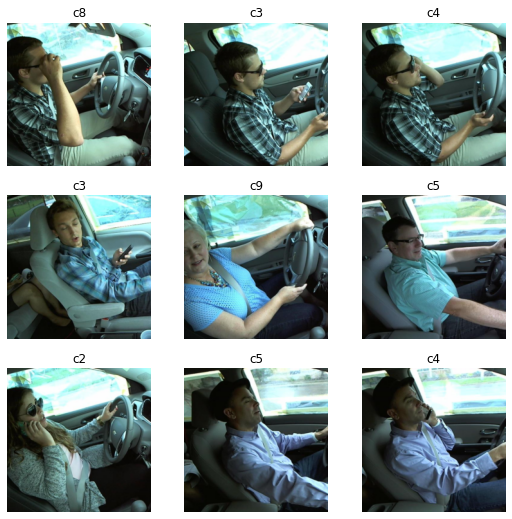

In [6]:
def classe(x):
    return (driver.loc[driver.img==x, "classname"].values[0])

path = "imgs/train"
dls = ImageDataLoaders.from_name_func(
    path, 
    get_image_files(path), 
    valid_pct=0.25, 
    seed=seed, 
    label_func=classe, 
    item_tfms=Resize(224),
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

dls.show_batch()

***Question 3:  Déterminez les différentes strates ou aspects de ces images puis construisez un ensemble
de validation équilibré entre ces dernières en vous basant sur les infos de ce dataset
mentionné à la fin du notebook “lesson1_cnn”. Le ratio de l’ensemble de validation doit
être de 25%.***

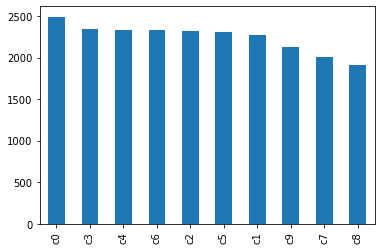

In [7]:
class_count = driver.classname.value_counts()
fig = class_count.plot(kind='bar')

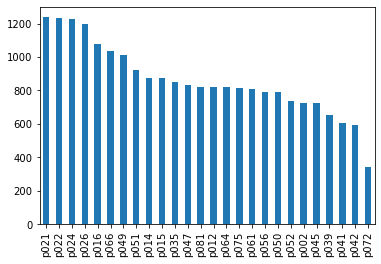

In [8]:
subject_count = driver.subject.value_counts()
fig = subject_count.plot(kind='bar')

In [9]:
driver = driver.assign(use_in_test=False)
driver.sample(5)

,subject,classname,img,use_in_test
13358,p047,c8,img_18354.jpg,False
8863,p026,c6,img_14529.jpg,False
16465,p052,c2,img_15992.jpg,False
18581,p061,c9,img_30893.jpg,False
2501,p015,c0,img_43958.jpg,False


#### Création du jeu de validation

In [10]:
# nous créons un dataframe contenant les proportions par classe et par sujet que nous utiliserons plus tard
driver.use_in_test = False

prop_subject = driver.groupby(["subject", "classname"]).count() / driver.shape[0] * 100
prop_subject_classe = pd.DataFrame({
    "subject": prop_subject.index.get_level_values('subject'),
    "classname": prop_subject.index.get_level_values('classname'), "prop": prop_subject.img.values
})
display(prop_subject_classe.sample(5))

# nous créons un dataframe contenant les proportions par classe que nous utiliserons plus tard
prop_classe = driver.classname.value_counts() / driver.shape[0] * 100
prop_classe = pd.DataFrame({'classname': prop_classe.index, 'prop': (prop_classe.values * 0.25)})
# display(prop_classe)

# A cette étape nous recherchons toutes les combinaisons possible de 6 sujets parmis les 26
# Pourquoi 6, parce qu'en effectutant différents auparavant nous avons remarqué que avec 6 nous
# avons plus de chance de respecter les 3 conditions que nous nous sommes fixées
comb = [seq for seq in itertools.combinations(driver.subject.unique(), 6)]

# nous effectuons une boucle sur chaque combinaisons et vérifions si elle respecte nos différents conditions
# chaque combinaison représente les sujets que nous utiliserons en test
for cb in comb:
    # nous calculons la proportion de chaque classe parmis les sujets que nous avons choisi(ceux de la combinaison)
    prop_comb_classe = prop_subject_classe.loc[prop_subject_classe.subject.isin(cb)].groupby("classname").sum()
   
    # on soustrait les proprortions calculées précédemment à celle qui sont censées être
    # et vu qu'on ne peut avoir exactement les meêmes proportions on se permet de faire une erreur à la virgule près
    # et si la différence en valeur absolue est inférieur à un epsilon (taux d'erreur) alors nos conditions sont vérifier pour une  classe
    # cette vérification se fait pour chaque classe et donnc au final la comme des conditons devra donner 10 (d'où la condition)
    condition = abs(prop_comb_classe.prop.values - prop_classe.prop.values) <= (0.001 * 100)    
    if sum(condition) == 10:
        # cb_0 contiendra notre oracle (la combinaison parfaite)
        cb_0 = cb
        break
        
driver.loc[driver.subject.isin(cb_0), 'use_in_test'] = True

,subject,classname,prop
123,p042,c3,0.263111
219,p064,c9,0.338923
218,p064,c8,0.361220
28,p014,c8,0.169461
16,p012,c6,0.334463


In [11]:
driver.loc[:, "path"] = driver.loc[:, "classname"].astype("str") + '/' + driver.loc[:, "img"].astype("str")
driver.sample(5)  

,subject,classname,img,use_in_test,path
16598,p052,c4,img_4736.jpg,False,c4/img_4736.jpg
11318,p041,c9,img_31051.jpg,False,c9/img_31051.jpg
11042,p041,c4,img_36887.jpg,False,c4/img_36887.jpg
7143,p024,c2,img_54315.jpg,False,c2/img_54315.jpg
15695,p051,c3,img_81736.jpg,False,c3/img_81736.jpg


Nous chargeons nos données avec le bon jeu de validation

In [12]:
dls = ImageDataLoaders.from_df(
    driver,
    'imgs/', 
    folder='train', 
    valid_col='use_in_test', 
    fn_col=4, 
    item_tfms=Resize(224),
    label_col=1,
    seed=seed,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

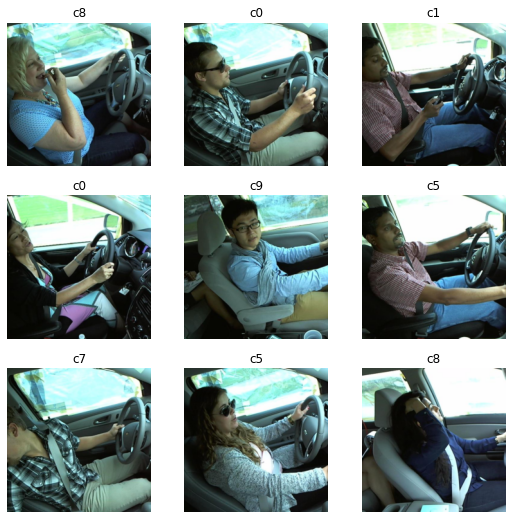

In [13]:
dls.show_batch()

***Question 4. Entraînez votre modèle (apprentissage par transfert) pendant 5 époques en prenant le
soin d’utiliser le rythme d’apprentissage optimal fourni par fastai.***

In [14]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

/home/rk/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Recherche du meilleur learning rate

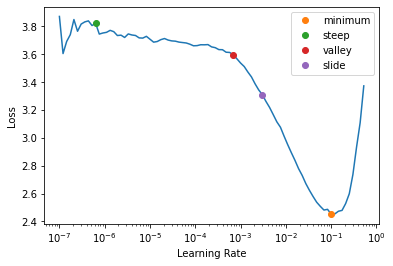

In [15]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [16]:
lr_min = lrs.minimum
lr_min

0.010000000149011612

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.440371,1.571108,0.344680,0.655320,03:00


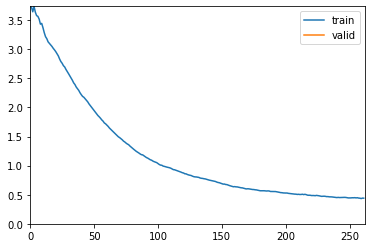

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.136124,0.819401,0.190340,0.809660,01:37
1,0.070625,0.903229,0.229549,0.770451,01:43
2,0.050606,0.734054,0.162716,0.837284,01:48
3,0.009230,0.818058,0.189984,0.810016,01:53
4,0.002075,0.678068,0.150419,0.849581,01:57


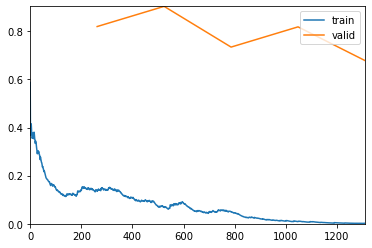

In [17]:
learn.fine_tune(epochs=5, base_lr=lrs.minimum, cbs=[ShowGraphCallback(),])

In [18]:
learn.save("./somnolence_model_q4")

Path('imgs/models/somnolence_model_q4.pth')

***Question 5: Entraînez votre modèle à nouveau jusqu’à la dégradation (forte augmentation) du loss de
l’ensemble de validation. Précisez le numéro de l’époque où cette divergence du loss a
débuté et la meilleure performance obtenue.***

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.439840,1.644225,0.362680,0.637320,01:31


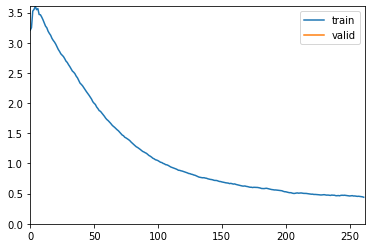

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.072073,0.834539,0.206559,0.793441,01:57
1,0.084277,0.979849,0.216361,0.783639,02:01
2,0.075113,0.709353,0.167885,0.832115,02:00
3,0.063699,1.041579,0.196578,0.803422,02:04
4,0.039996,0.533091,0.126359,0.873641,02:02
5,0.068160,0.792555,0.179469,0.820531,02:00
6,0.021809,0.694644,0.158973,0.841027,02:04
7,0.018739,0.656927,0.137587,0.862413,02:00
8,0.015732,0.716425,0.139904,0.860096,01:59
9,0.007214,0.561978,0.126715,0.873285,02:01


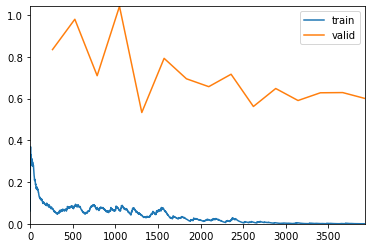

In [19]:
learn2 = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])
learn2.fine_tune(epochs=15, base_lr=lr_min, cbs=[ShowGraphCallback(),])

In [20]:
learn2.save("./somnolence_model_q5")

Path('imgs/models/somnolence_model_q5.pth')

***Question 6. Entraînez de nouveau votre modèle en effectuant des changements de sorte à améliorer
la performance du modèle. Il est recommandé de lire la documentation afin de découvrir
certaines techniques d’apprentissage améliorant la performance de votre modèle.***

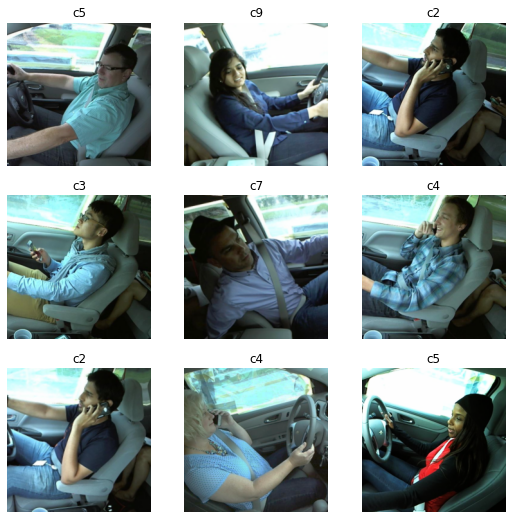

In [21]:
augmentations = [
        Rotate(10, p=0.4, mode='bilinear'), 
        Brightness(max_lighting=0.3,p=0.5),
        Contrast(max_lighting=0.4, p=0.5),
        RandomErasing(p=0.3, sl=0.0, sh=0.2, min_aspect=0.3, max_count=1),
        Flip(p=0.5),
        Zoom(max_zoom=1,p=0.5),
        RandomResizedCrop(224)
    ]

dls_aug = ImageDataLoaders.from_df(
    driver,
    'imgs/', 
    folder='train', 
    valid_col='use_in_test', 
    fn_col=4, 
    item_tfms=Resize(224),
    batch_tfms=augmentations,
    label_col=1,
    seed=seed,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

dls_aug.show_batch()

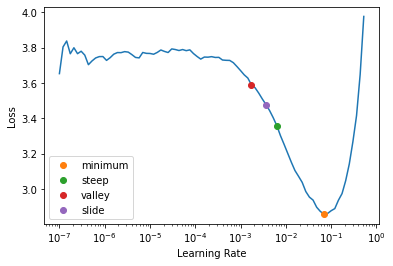

In [22]:
learn_aug = cnn_learner(dls_aug, resnet18, metrics=[error_rate, accuracy])
lrs_aug = learn_aug.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [23]:
lr_min_aug = lrs_aug.minimum
lr_min_aug

0.006918309628963471

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.866891,1.360189,0.381928,0.618072,01:40


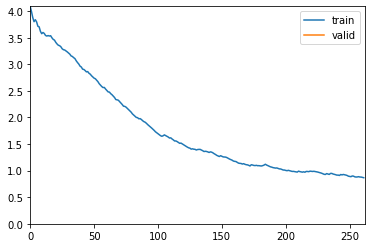

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.172896,0.731823,0.213331,0.786669,02:08
1,0.099444,0.638124,0.174479,0.825521,02:13
2,0.128250,0.929467,0.227232,0.772768,02:11
3,0.124560,0.693236,0.189628,0.810372,02:08
4,0.098759,0.567948,0.143646,0.856354,02:09
5,0.096131,0.832561,0.184459,0.815541,02:07
6,0.049370,0.798309,0.181429,0.818571,02:08
7,0.057227,0.623700,0.160043,0.839957,02:10
8,0.047177,0.522966,0.137943,0.862057,02:12
9,0.029661,0.649353,0.153805,0.846195,02:11


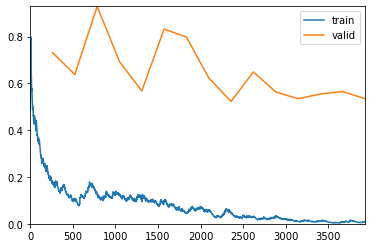

In [24]:
learn_aug.fine_tune(epochs=15, base_lr=lr_min_aug, cbs=[ShowGraphCallback(),])

In [25]:
learn_aug.save("./somnolence_model_q6")

Path('imgs/models/somnolence_model_q6.pth')

***Question 7. Présentez les résultats de votre modèle et critiquez-le.***

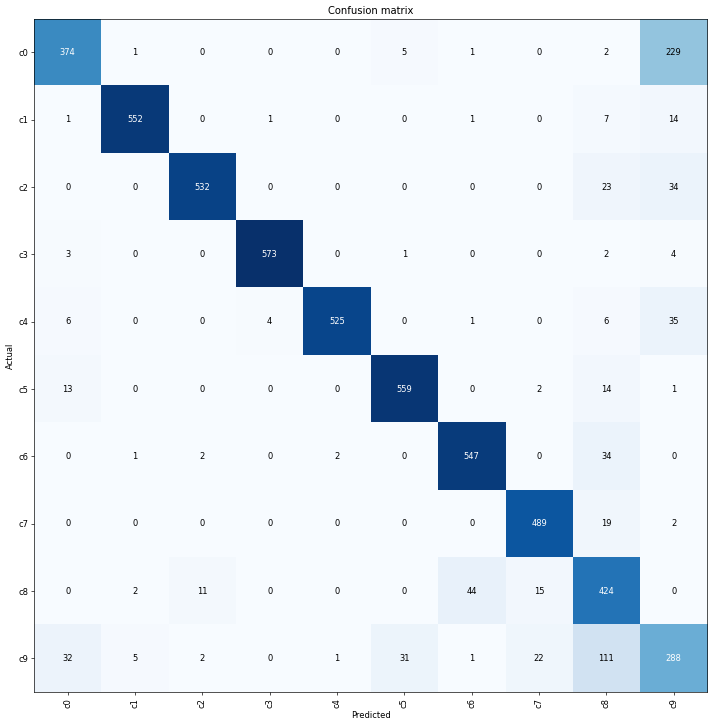

In [26]:
interp = ClassificationInterpretation.from_learner(learn_aug)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.print_classification_report()

              precision    recall  f1-score   support

          c0       0.87      0.61      0.72       612
          c1       0.98      0.96      0.97       576
          c2       0.97      0.90      0.94       589
          c3       0.99      0.98      0.99       583
          c4       0.99      0.91      0.95       577
          c5       0.94      0.95      0.94       589
          c6       0.92      0.93      0.93       586
          c7       0.93      0.96      0.94       510
          c8       0.66      0.85      0.75       496
          c9       0.47      0.58      0.52       493

    accuracy                           0.87      5611
   macro avg       0.87      0.86      0.86      5611
weighted avg       0.88      0.87      0.87      5611



***Question 8: À l’aide des outils vus en cours, diagnostiquez 6 prédictions à raison de 2 prédictions pour
chacune des 3 classes ayant enregistré les plus mauvaises performances. Expliquez les
raisons de ces erreurs pour chaque classe. Quelles suggestions pouvez vous faire pour
l’amélioration du modèle ?***

/home/rk/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


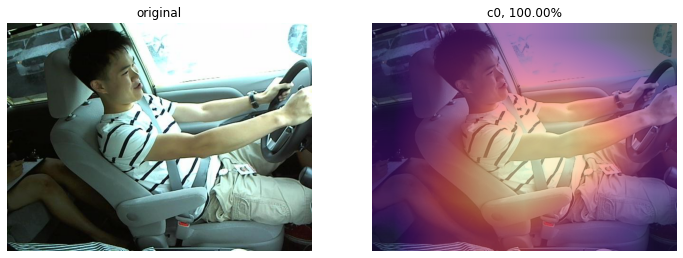

In [28]:
def grad_cam(index):
    path = str(dls_aug.items.loc[index, 'path'])
    path = f'imgs/train/{path}'
    gcam = GradCam(learn=learn_aug, fname=path, labels=None) #plots highest prediction
    gcam.plot(full_size=True, plot_original=True, figsize=(12,6))
grad_cam(0)

In [29]:
interp.most_confused(min_val=55)

[('c0', 'c9', 229), ('c9', 'c8', 111)]